# Method 2 - Best Ideas Medium Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['herf_pct'] > (1 / 3)) & (best_ideas['herf_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

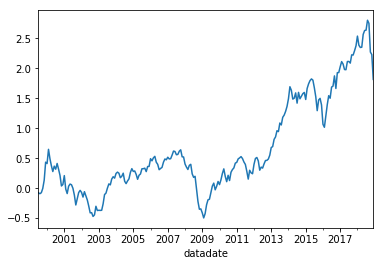

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.433616
2000-12-31   -0.259485
2001-12-31   -0.092556
2002-12-31   -0.348688
2003-12-31    0.860488
2004-12-31    0.135471
2005-12-31    0.028401
2006-12-31    0.081161
2007-12-31    0.031613
2008-12-31   -0.569442
2009-12-31    0.698272
2010-12-31    0.275180
2011-12-31   -0.124886
2012-12-31    0.250613
2013-12-31    0.524060
2014-12-31    0.098337
2015-12-31   -0.080219
2016-12-31    0.225913
2017-12-31    0.152574
2018-12-31   -0.166069
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     468.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.27e-109
Time:                        23:28:39   Log-Likelihood:                 528.59
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.122      0.035       0.000       0.007
mktrf          1.1549      0.048     24.235      0.000       1.061       1.249
me             0.4657      0.055      8.402      0.000       0.357       0.575
ia            -0.1339      0.084     -1.590      0.113      -0.300       0.032
roe           -0.6901      0.072     -9.570      0.000      -0.832      -0.548
==============================================================================
Omnibus:                       53.963   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.228
Skew:                           0.952   Prob(JB):                     2.95e-37
Kurtosis:                       6.691   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     343.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.63e-95
Time:                        23:28:39   Log-Likelihood:                 528.59
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.936      0.053   -4.63e-05       0.007
mktrf          1.1549      0.045     25.913      0.000       1.068       1.242
me             0.4657      0.049      9.497      0.000       0.370       0.562
ia            -0.1339      0.135     -0.993      0.321      -0.398       0.131
roe           -0.6901      0.129     -5.347      0.000      -0.943      -0.437
==============================================================================
Omnibus:                       53.963   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.228
Skew:                           0.952   Prob(JB):                     2.95e-37
Kurtosis:                       6.691   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     516.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.55e-113
Time:                        23:28:39   Log-Likelihood:                 528.59
No. Observations:                 234   AIC:                            -1047.
Df Residuals:                     229   BIC:                            -1030.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.084      0.037       0.000       0.007
mktrf          1.1549      0.045     25.892      0.000       1.067       1.242
me             0.4657      0.052      8.996      0.000       0.364       0.567
ia            -0.1339      0.115     -1.164      0.245      -0.360       0.092
roe           -0.6901      0.140     -4.932      0.000      -0.964      -0.416
==============================================================================
Omnibus:                       53.963   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.228
Skew:                           0.952   Prob(JB):                     2.95e-37
Kurtosis:                       6.691   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     342.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.06e-104
Time:                        23:28:39   Log-Likelihood:                 519.68
No. Observations:                 234   AIC:                            -1027.
Df Residuals:                     228   BIC:                            -1007.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.817      0.071      -0.000       0.007
mktrf          1.2135      0.050     24.411      0.000       1.116       1.311
smb            0.4943      0.066      7.536      0.000       0.365       0.624
hml            0.0935      0.077      1.209      0.228      -0.059       0.246
rmw           -0.6596      0.087     -7.543      0.000      -0.832      -0.487
cma           -0.0806      0.111     -0.725      0.469      -0.300       0.138
==============================================================================
Omnibus:                       47.025   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.627
Skew:                           0.870   Prob(JB):                     1.17e-28
Kurtosis:                       6.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     164.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.49e-73
Time:                        23:28:39   Log-Likelihood:                 519.68
No. Observations:                 234   AIC:                            -1027.
Df Residuals:                     228   BIC:                            -1007.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.719      0.086      -0.000       0.007
mktrf          1.2135      0.049     24.951      0.000       1.118       1.309
smb            0.4943      0.065      7.615      0.000       0.367       0.622
hml            0.0935      0.112      0.834      0.404      -0.126       0.313
rmw           -0.6596      0.143     -4.620      0.000      -0.939      -0.380
cma           -0.0806      0.156     -0.518      0.604      -0.386       0.224
==============================================================================
Omnibus:                       47.025   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.627
Skew:                           0.870   Prob(JB):                     1.17e-28
Kurtosis:                       6.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     184.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.62e-78
Time:                        23:28:39   Log-Likelihood:                 519.68
No. Observations:                 234   AIC:                            -1027.
Df Residuals:                     228   BIC:                            -1007.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.809      0.070      -0.000       0.007
mktrf          1.2135      0.051     23.766      0.000       1.113       1.314
smb            0.4943      0.059      8.371      0.000       0.379       0.610
hml            0.0935      0.092      1.016      0.309      -0.087       0.274
rmw           -0.6596      0.152     -4.328      0.000      -0.958      -0.361
cma           -0.0806      0.144     -0.561      0.575      -0.362       0.201
==============================================================================
Omnibus:                       47.025   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.627
Skew:                           0.870   Prob(JB):                     1.17e-28
Kurtosis:                       6.189   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     383.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.87e-100
Time:                        23:28:39   Log-Likelihood:                 508.01
No. Observations:                 234   AIC:                            -1006.
Df Residuals:                     229   BIC:                            -988.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.578      0.564      -0.003       0.005
mktrf          1.2881      0.048     26.887      0.000       1.194       1.383
smb            0.7616      0.060     12.736      0.000       0.644       0.879
hml           -0.0803      0.059     -1.351      0.178      -0.197       0.037
umd           -0.2229      0.039     -5.719      0.000      -0.300      -0.146
==============================================================================
Omnibus:                       53.509   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.297
Skew:                           0.909   Prob(JB):                     1.58e-40
Kurtosis:                       6.936   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     208.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.86e-75
Time:                        23:28:39   Log-Likelihood:                 508.01
No. Observations:                 234   AIC:                            -1006.
Df Residuals:                     229   BIC:                            -988.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.578      0.563      -0.003       0.005
mktrf          1.2881      0.059     21.759      0.000       1.172       1.404
smb            0.7616      0.065     11.792      0.000       0.635       0.888
hml           -0.0803      0.088     -0.915      0.360      -0.252       0.092
umd           -0.2229      0.068     -3.275      0.001      -0.356      -0.089
==============================================================================
Omnibus:                       53.509   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.297
Skew:                           0.909   Prob(JB):                     1.58e-40
Kurtosis:                       6.936   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     210.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.56e-75
Time:                        23:28:39   Log-Likelihood:                 508.01
No. Observations:                 234   AIC:                            -1006.
Df Residuals:                     229   BIC:                            -988.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.653      0.514      -0.002       0.004
mktrf          1.2881      0.054     24.062      0.000       1.183       1.393
smb            0.7616      0.067     11.408      0.000       0.631       0.892
hml           -0.0803      0.074     -1.082      0.279      -0.226       0.065
umd           -0.2229      0.064     -3.473      0.001      -0.349      -0.097
==============================================================================
Omnibus:                       53.509   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.297
Skew:                           0.909   Prob(JB):                     1.58e-40
Kurtosis:                       6.936   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     226.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-53
Time:                        23:28:39   Log-Likelihood:                 249.21
No. Observations:                 120   AIC:                            -488.4
Df Residuals:                     115   BIC:                            -474.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.750      0.083      -0.001       0.011
mktrf          1.2120      0.080     15.178      0.000       1.054       1.370
me             0.4433      0.079      5.620      0.000       0.287       0.599
ia            -0.1418      0.124     -1.148      0.253      -0.386       0.103
roe           -0.6222      0.109     -5.692      0.000      -0.839      -0.406
==============================================================================
Omnibus:                       25.782   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.434
Skew:                           0.880   Prob(JB):                     4.11e-12
Kurtosis:                       5.718   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     152.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.04e-45
Time:                        23:28:39   Log-Likelihood:                 249.21
No. Observations:                 120   AIC:                            -488.4
Df Residuals:                     115   BIC:                            -474.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.522      0.128      -0.001       0.012
mktrf          1.2120      0.070     17.289      0.000       1.075       1.349
me             0.4433      0.065      6.855      0.000       0.317       0.570
ia            -0.1418      0.185     -0.768      0.442      -0.504       0.220
roe           -0.6222      0.174     -3.574      0.000      -0.963      -0.281
==============================================================================
Omnibus:                       25.782   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.434
Skew:                           0.880   Prob(JB):                     4.11e-12
Kurtosis:                       5.718   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     261.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.55e-57
Time:                        23:28:39   Log-Likelihood:                 249.21
No. Observations:                 120   AIC:                            -488.4
Df Residuals:                     115   BIC:                            -474.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.645      0.100      -0.001       0.011
mktrf          1.2120      0.070     17.366      0.000       1.075       1.349
me             0.4433      0.069      6.445      0.000       0.308       0.578
ia            -0.1418      0.163     -0.868      0.386      -0.462       0.178
roe           -0.6222      0.190     -3.274      0.001      -0.995      -0.250
==============================================================================
Omnibus:                       25.782   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.434
Skew:                           0.880   Prob(JB):                     4.11e-12
Kurtosis:                       5.718   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     177.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.39e-52
Time:                        23:28:39   Log-Likelihood:                 248.61
No. Observations:                 120   AIC:                            -485.2
Df Residuals:                     114   BIC:                            -468.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      1.996      0.048    4.53e-05       0.012
mktrf          1.3257      0.085     15.598      0.000       1.157       1.494
smb            0.4872      0.096      5.061      0.000       0.296       0.678
hml            0.0134      0.118      0.114      0.909      -0.220       0.247
rmw           -0.5473      0.139     -3.935      0.000      -0.823      -0.272
cma            0.0007      0.152      0.004      0.997      -0.301       0.303
==============================================================================
Omnibus:                       20.657   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.534
Skew:                           0.758   Prob(JB):                     1.17e-08
Kurtosis:                       5.238   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     113.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-42
Time:                        23:28:39   Log-Likelihood:                 248.61
No. Observations:                 120   AIC:                            -485.2
Df Residuals:                     114   BIC:                            -468.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      1.971      0.049    3.29e-05       0.012
mktrf          1.3257      0.073     18.176      0.000       1.183       1.469
smb            0.4872      0.088      5.516      0.000       0.314       0.660
hml            0.0134      0.145      0.093      0.926      -0.270       0.297
rmw           -0.5473      0.186     -2.938      0.003      -0.912      -0.182
cma            0.0007      0.171      0.004      0.997      -0.334       0.335
==============================================================================
Omnibus:                       20.657   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.534
Skew:                           0.758   Prob(JB):                     1.17e-08
Kurtosis:                       5.238   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     175.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.26e-52
Time:                        23:28:39   Log-Likelihood:                 248.61
No. Observations:                 120   AIC:                            -485.2
Df Residuals:                     114   BIC:                            -468.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      2.056      0.040       0.000       0.012
mktrf          1.3257      0.064     20.832      0.000       1.201       1.450
smb            0.4872      0.078      6.228      0.000       0.334       0.640
hml            0.0134      0.125      0.107      0.915      -0.232       0.259
rmw           -0.5473      0.201     -2.726      0.006      -0.941      -0.154
cma            0.0007      0.149      0.004      0.996      -0.291       0.293
==============================================================================
Omnibus:                       20.657   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.534
Skew:                           0.758   Prob(JB):                     1.17e-08
Kurtosis:                       5.238   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     214.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.53e-52
Time:                        23:28:39   Log-Likelihood:                 246.29
No. Observations:                 120   AIC:                            -482.6
Df Residuals:                     115   BIC:                            -468.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.250      0.214      -0.002       0.010
mktrf          1.3865      0.072     19.236      0.000       1.244       1.529
smb            0.7342      0.082      8.946      0.000       0.572       0.897
hml           -0.1084      0.082     -1.318      0.190      -0.271       0.054
umd           -0.1953      0.051     -3.854      0.000      -0.296      -0.095
==============================================================================
Omnibus:                       22.611   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.305
Skew:                           0.697   Prob(JB):                     1.61e-12
Kurtosis:                       5.986   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     148.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.06e-44
Time:                        23:28:39   Log-Likelihood:                 246.29
No. Observations:                 120   AIC:                            -482.6
Df Residuals:                     115   BIC:                            -468.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.237      0.216      -0.002       0.010
mktrf          1.3865      0.082     16.866      0.000       1.225       1.548
smb            0.7342      0.090      8.157      0.000       0.558       0.911
hml           -0.1084      0.111     -0.973      0.330      -0.327       0.110
umd           -0.1953      0.080     -2.430      0.015      -0.353      -0.038
==============================================================================
Omnibus:                       22.611   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.305
Skew:                           0.697   Prob(JB):                     1.61e-12
Kurtosis:                       5.986   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     202.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.22e-51
Time:                        23:28:39   Log-Likelihood:                 246.29
No. Observations:                 120   AIC:                            -482.6
Df Residuals:                     115   BIC:                            -468.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.461      0.144      -0.001       0.009
mktrf          1.3865      0.060     23.218      0.000       1.269       1.504
smb            0.7342      0.094      7.822      0.000       0.550       0.918
hml           -0.1084      0.095     -1.144      0.253      -0.294       0.077
umd           -0.1953      0.071     -2.761      0.006      -0.334      -0.057
==============================================================================
Omnibus:                       22.611   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.305
Skew:                           0.697   Prob(JB):                     1.61e-12
Kurtosis:                       5.986   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     261.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.68e-55
Time:                        23:28:39   Log-Likelihood:                 296.78
No. Observations:                 114   AIC:                            -583.6
Df Residuals:                     109   BIC:                            -569.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.627      0.107      -0.001       0.007
mktrf          1.0869      0.054     20.181      0.000       0.980       1.194
me             0.5419      0.083      6.517      0.000       0.377       0.707
ia            -0.1621      0.115     -1.405      0.163      -0.391       0.067
roe           -0.8238      0.101     -8.128      0.000      -1.025      -0.623
==============================================================================
Omnibus:                       13.902   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.867
Skew:                           0.607   Prob(JB):                     4.85e-05
Kurtosis:                       4.646   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     605.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.89e-73
Time:                        23:28:39   Log-Likelihood:                 296.78
No. Observations:                 114   AIC:                            -583.6
Df Residuals:                     109   BIC:                            -569.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.948      0.051   -1.81e-05       0.006
mktrf          1.0869      0.046     23.387      0.000       0.996       1.178
me             0.5419      0.045     12.035      0.000       0.454       0.630
ia            -0.1621      0.124     -1.306      0.192      -0.405       0.081
roe           -0.8238      0.099     -8.324      0.000      -1.018      -0.630
==============================================================================
Omnibus:                       13.902   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.867
Skew:                           0.607   Prob(JB):                     4.85e-05
Kurtosis:                       4.646   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     1093.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.90e-87
Time:                        23:28:39   Log-Likelihood:                 296.78
No. Observations:                 114   AIC:                            -583.6
Df Residuals:                     109   BIC:                            -569.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      1.998      0.046    5.65e-05       0.006
mktrf          1.0869      0.036     29.793      0.000       1.015       1.158
me             0.5419      0.036     15.055      0.000       0.471       0.612
ia            -0.1621      0.120     -1.353      0.176      -0.397       0.073
roe           -0.8238      0.079    -10.494      0.000      -0.978      -0.670
==============================================================================
Omnibus:                       13.902   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.867
Skew:                           0.607   Prob(JB):                     4.85e-05
Kurtosis:                       4.646   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     169.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.16e-49
Time:                        23:28:39   Log-Likelihood:                 286.36
No. Observations:                 114   AIC:                            -560.7
Df Residuals:                     108   BIC:                            -544.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.582      0.562      -0.003       0.005
mktrf          1.1242      0.057     19.884      0.000       1.012       1.236
smb            0.5315      0.092      5.791      0.000       0.350       0.713
hml            0.0829      0.117      0.708      0.480      -0.149       0.315
rmw           -0.8421      0.143     -5.875      0.000      -1.126      -0.558
cma           -0.1207      0.182     -0.663      0.509      -0.481       0.240
==============================================================================
Omnibus:                        0.539   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.459
Skew:                           0.154   Prob(JB):                        0.795
Kurtosis:                       2.956   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     129.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.87e-44
Time:                        23:28:39   Log-Likelihood:                 286.36
No. Observations:                 114   AIC:                            -560.7
Df Residuals:                     108   BIC:                            -544.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.610      0.542      -0.003       0.005
mktrf          1.1242      0.060     18.625      0.000       1.006       1.242
smb            0.5315      0.074      7.143      0.000       0.386       0.677
hml            0.0829      0.142      0.584      0.560      -0.195       0.361
rmw           -0.8421      0.213     -3.953      0.000      -1.260      -0.425
cma           -0.1207      0.178     -0.678      0.498      -0.470       0.228
==============================================================================
Omnibus:                        0.539   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.459
Skew:                           0.154   Prob(JB):                        0.795
Kurtosis:                       2.956   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     200.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.42e-53
Time:                        23:28:39   Log-Likelihood:                 286.36
No. Observations:                 114   AIC:                            -560.7
Df Residuals:                     108   BIC:                            -544.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.667      0.505      -0.002       0.005
mktrf          1.1242      0.060     18.849      0.000       1.007       1.241
smb            0.5315      0.067      7.929      0.000       0.400       0.663
hml            0.0829      0.152      0.546      0.585      -0.215       0.381
rmw           -0.8421      0.210     -4.006      0.000      -1.254      -0.430
cma           -0.1207      0.190     -0.635      0.526      -0.493       0.252
==============================================================================
Omnibus:                        0.539   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.459
Skew:                           0.154   Prob(JB):                        0.795
Kurtosis:                       2.956   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     164.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.64e-45
Time:                        23:28:39   Log-Likelihood:                 273.28
No. Observations:                 114   AIC:                            -536.6
Df Residuals:                     109   BIC:                            -522.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.136e-05      0.002      0.023      0.982      -0.004       0.004
mktrf          1.1636      0.063     18.552      0.000       1.039       1.288
smb            0.7315      0.098      7.480      0.000       0.538       0.925
hml            0.0800      0.101      0.794      0.429      -0.120       0.280
umd           -0.2025      0.076     -2.665      0.009      -0.353      -0.052
==============================================================================
Omnibus:                       18.350   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.660
Skew:                           0.750   Prob(JB):                     5.98e-07
Kurtosis:                       4.945   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     191.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.46e-48
Time:                        23:28:39   Log-Likelihood:                 273.28
No. Observations:                 114   AIC:                            -536.6
Df Residuals:                     109   BIC:                            -522.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.136e-05      0.002      0.029      0.977      -0.003       0.004
mktrf          1.1636      0.060     19.491      0.000       1.047       1.281
smb            0.7315      0.084      8.675      0.000       0.566       0.897
hml            0.0800      0.162      0.494      0.622      -0.238       0.398
umd           -0.2025      0.087     -2.340      0.019      -0.372      -0.033
==============================================================================
Omnibus:                       18.350   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.660
Skew:                           0.750   Prob(JB):                     5.98e-07
Kurtosis:                       4.945   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     203.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.49e-49
Time:                        23:28:39   Log-Likelihood:                 273.28
No. Observations:                 114   AIC:                            -536.6
Df Residuals:                     109   BIC:                            -522.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.136e-05      0.002      0.031      0.975      -0.003       0.003
mktrf          1.1636      0.055     21.282      0.000       1.056       1.271
smb            0.7315      0.068     10.801      0.000       0.599       0.864
hml            0.0800      0.166      0.481      0.631      -0.246       0.406
umd           -0.2025      0.080     -2.522      0.012      -0.360      -0.045
==============================================================================
Omnibus:                       18.350   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.660
Skew:                           0.750   Prob(JB):                     5.98e-07
Kurtosis:                       4.945   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""